In [1]:
1+1

2

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
from langchain_openai import OpenAIEmbeddings
embedding = OpenAIEmbeddings(model="text-embedding-3-large")

In [4]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', streaming=True)
small_llm = ChatOpenAI(model='gpt-4o-mini', streaming=True)

In [5]:
from langchain_chroma import Chroma

# vector_store = Chroma.from_documents(
#     documents=document_list,
#     embedding=embedding,
#     collection_name="chroma_tax",
#     persist_directory="./chroma_tax"
# )

vector_store = Chroma(
    collection_name="chroma_tax",
    embedding_function=embedding,
    persist_directory="./chroma_tax"
)

In [6]:
retriever = vector_store.as_retriever(search_kwargs={"k" : 3})
retriever

VectorStoreRetriever(tags=['Chroma', 'OpenAIEmbeddings'], vectorstore=<langchain_chroma.vectorstores.Chroma object at 0x00000216E13A3C10>, search_kwargs={'k': 3})

In [7]:
from typing_extensions import List, TypedDict
from langchain_core.documents import Document
from langgraph.graph import StateGraph, MessagesState
from typing import Literal
# 기존 import 수정
from typing_extensions import TypedDict  # ✅ typing 대신 typing_extensions 사용

class AgentState(MessagesState):
    pass    #messages무조건 있음. 
    # query: str
    # context: List[Document]     #retriever에 있는 문서에서 읽어오겠다
    # answer : str
    
graph_builder = StateGraph(MessagesState)

In [8]:
#전체 문서를 하나의 문서로 통합
def format_docs(docs):
    return "\n\n".join([doc.page_content for doc in docs])

In [9]:
from langchain_core.tools import tool

@tool
def retrieve_tool(query: str) -> str:
    """
    사용자의 질문에 기반하여 벡터 스토어에서 관련 문서를 검색합니다.
    
    Args:
        query (str): 검색할 질문
        
    Returns:
        str: 검색된 문서 내용
    """
    docs = retriever.invoke(query)
    return format_docs(docs)

In [10]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

@tool
def generate_tool(context: str, question: str) -> str:
    """
    검색된 문서(context)와 질문을 바탕으로 응답을 생성하는 도구입니다. 
    """
    
    prompt = PromptTemplate.from_template("""
    다음은 질문에 대한 문서입니다. 문서를 참고해서 질문에 대한 정확한 답변을 생성해주세요. 
    
    [문서]
    {context}
    
    [질문]
    {question}    
    """)
    
    chain = prompt | llm | StrOutputParser()
    
    return chain.invoke({'context': context, 'question': question})



In [11]:
dictionary = ["사람과 관련된 표현 -> 거주자"]

rewrite_prompt = PromptTemplate.from_template(f"""
사용자의 질문을 보고, 우리의 사전을 참고해서 사용자의 질문을 변경해주세요.
사전: {dictionary}
질문: {{query}}     
""")
# f-string사용해서 {}한번 더 해줘야함. 

In [12]:
# from langchain_core.prompts import PromptTemplate
# from langchain_core.output_parsers import StrOutputParser

@tool
def rewrite(query: str) -> str:
    """
    사용자의 질문을 사전을 고려하여 변경합니다. 

    """
    #chain
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()        
                                            #전체를 str로 반환. 이게 다시 질문이 되야하기 때문
    # response = rewrite_chain.invoke({'query': query})
    
    return rewrite_chain.invoke({'query': query})

In [13]:
from langgraph.prebuilt import ToolNode
 
tool_list = [retrieve_tool, generate_tool, rewrite]
tool_node = ToolNode(tool_list)
llm_with_tools = llm.bind_tools(tool_list)

In [14]:
from langchain_core.messages import HumanMessage, SystemMessage

def agent(state: AgentState) -> AgentState:
    system_msg = SystemMessage(content="너는 사용자 질문을 검색, 기가이팅, 응답 생성도구로 해결하는 AI임")
    messages = [system_msg] + state["messages"]
    response = llm_with_tools.invoke(messages)
    
    return {"messages": [response]}

In [15]:
#node
graph_builder = StateGraph(AgentState)

graph_builder.add_node('agent', agent)
graph_builder.add_node('tools', tool_node)


In [ ]:
from langgraph.graph import START, END
from langgraph.prebuilt import tools_condition

graph_builder.add_edge(START, 'agent')
graph_builder.add_conditional_edges('agent', tools_condition)
    #tools_condition : tool계속 호출할지 말지 판단 
graph_builder.add_edge('tools', 'agent')
# graph_builder.add_edge('generate', END)



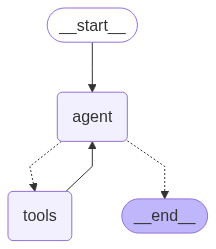

In [17]:
from IPython.display import Image, display
graph = graph_builder.compile()

# display(Image(graph.get_graph().draw_mermaid_png()))
graph

In [18]:
from langchain_core.messages import HumanMessage, SystemMessage

query = '연봉 5천만원 직장인의 소득세는 얼마인가요?'
init_state = {"messages": [HumanMessage(content=query)] }

for chunk in graph.stream(init_state, stream_mode='values'):
    chunk['messages'][-1].pretty_print()


================================ Human Message =================================

연봉 5천만원 직장인의 소득세는 얼마인가요?
================================== Ai Message ==================================

연봉 5천만 원에 대한 소득세를 계산하기 위해서는 대한민국의 소득세율을 적용해야 합니다. 하지만 소득세 계산은 단순히 세율을 적용하는 것뿐만 아니라, 여러 공제 항목과 누진세율이 적용되기 때문에 정확한 금액을 계산하기 위해서는 추가적인 정보가 필요합니다. 일반적인 경우를 가정하여 대략적인 소득세를 계산해드리겠습니다.

대한민국의 소득세율은 다음과 같습니다(2023년 기준):
- 1,200만 원 이하: 6%
- 1,200만 원 초과 ~ 4,600만 원 이하: 15%
- 4,600만 원 초과 ~ 8,800만 원 이하: 24%
- 8,800만 원 초과 ~ 1억 5천만 원 이하: 35%
- 1억 5천만 원 초과 ~ 3억 원 이하: 38%
- 3억 원 초과: 40%

5천만 원의 연봉에 대한 소득세는 다음과 같이 계산됩니다.

1. 1,200만 원까지 6% 적용: 1,200만 원 × 6% = 72만 원
2. 1,200만 원 초과 4,600만 원까지 15% 적용: (4,600만 원 - 1,200만 원) × 15% = 510만 원
3. 4,600만 원 초과 5,000만 원까지 24% 적용: (5,000만 원 - 4,600만 원) × 24% = 96만 원

따라서 총 소득세는 72만 원 + 510만 원 + 96만 원 = 678만 원입니다.

하지만 실제 소득세는 공제 항목 및 기타 사항에 따라 달라질 수 있습니다. 정확한 금액은 국세청의 홈택스 또는 세무 전문가와 상담하시기를 권장드립니다.
